In [1]:
# define visible cuda devices to 6
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
import os
import jsonlines
import torch
from transformers import AutoTokenizer
from tqdm import tqdm
the_seed = 23

def load_jsonl(file_path):
    """Loads a JSONL file and returns a list of dictionaries."""
    try:
        with jsonlines.open(file_path, "r") as reader:
            return [obj for obj in reader]  # Read all JSON objects into a list
    except FileNotFoundError:
        print(f"Warning: File not found - {file_path}")
        return []
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

def load_dataset_splits(base_dir, model_id, splits=("train", "val", "test")):
    """
    Loads dataset splits from JSONL files.
    
    Args:
        base_dir (str): The base directory where dataset files are stored.
        model_id (str): The subdirectory for the model.
        splits (tuple): Dataset splits to load (default: train, val, test).

    Returns:
        dict: A dictionary with split names as keys and loaded data as values.
    """
    dataset = {}
    for split in splits:
        file_path = os.path.join(base_dir, model_id, f"{split}_wconf.jsonl")
        dataset[split] = load_jsonl(file_path)
    
    return dataset

# Define paths and load datasets
llm_id = "Llama-3.1-8B-Instruct"
wconf_dir_path = "../data/GSM8K/"
dataset = load_dataset_splits(wconf_dir_path, llm_id)

# Print dataset sizes
for split, data in dataset.items():
    print(f"{split.capitalize()} samples: {len(data)}")

/home/rkhanm1/anaconda3/envs/vllm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train samples: 5979
Val samples: 1494
Test samples: 1319


In [6]:
print(dataset.keys())
print('train:', dataset['train'][0].keys())
print('question:', dataset['train'][0]['question'][:100])
print('full_answer:', dataset['train'][0]['full_answer'][:100])
print('final_answer:', dataset['train'][0]['final_answer'])
print('empirical_confidence:', dataset['train'][0]['empirical_confidence'])
print('confidence_runs len:', len(dataset['train'][0]['confidence_runs']))
print('confidence_runs sample keys:', dataset['train'][0]['confidence_runs'][0].keys())
print('confidence_runs sample full_llm_answer:', dataset['train'][0]['confidence_runs'][0]['full_llm_answer'][:100])
print('confidence_runs sample final_llm_answer:', dataset['train'][0]['confidence_runs'][0]['final_llm_answer'])

dict_keys(['train', 'val', 'test'])
train: dict_keys(['question', 'full_answer', 'final_answer', 'empirical_confidence', 'confidence_runs'])
question: Summer and Jolly both went to the same middle school. However, when they finished college, Summer ha
full_answer: Jolly has 150 - 5 = <<150-5=145>>145 degrees
Since Summer has 150 degrees, the combined total for bo
final_answer: 295
empirical_confidence: 0.16666666666666666
confidence_runs len: 30
confidence_runs sample keys: dict_keys(['full_llm_answer', 'final_llm_answer'])
confidence_runs sample full_llm_answer: This question is identical to the first one provided. The correct solution to the problem is as foll
confidence_runs sample final_llm_answer: None


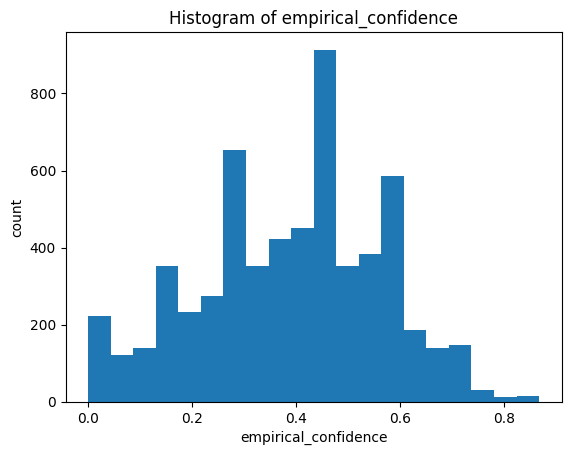

In [7]:
# create a histogram of empirical_confidence
import matplotlib.pyplot as plt

empirical_confidence = [item['empirical_confidence'] for item in dataset['train']]
plt.hist(empirical_confidence, bins=20)
plt.xlabel('empirical_confidence')
plt.ylabel('count')
plt.title('Histogram of empirical_confidence')
plt.show()

In [ ]:
def gsm8k_system_prompt():
    return "You are a mathematics expert. You will be given a mathematics problem which you need to solve. Provide the final answer clearly at the end in the format: #### <final answer>."

def load_few_shot_examples(gsm8k_path, nshots):
    file_path = os.path.join(gsm8k_path, f"{nshots}-shots.txt")
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read().strip()
    

def create_flattened_dataset(samples, few_shot_prompt, system_prompt, tokenizer):
    """
    For each sample in 'samples' (each representing one question), create
    a new record for each run (i.e. each LLM output in confidence_runs) using a chat conversation.
    
    The conversation is constructed as follows:
      - System: system_prompt
      - User: few_shot_prompt + "\nQuestion: {question}\nAnswer:"
      - Assistant: the LLM's generated answer (taken from run["full_llm_answer"])
    
    Each new record contains:
      - "input_str": the formatted conversation (using the chat template)
      - "empirical_confidence": the aggregated target (same for all runs of that question)
    
    Args:
        samples (list): List of original samples from the dataset.
        few_shot_prompt (str): The few-shot examples.
        system_prompt (str): The system instruction.
        tokenizer: The tokenizer that supports chat formatting.
        num_runs (int or None): If set, use only the first num_runs from each sample's confidence_runs.
    
    Returns:
        flattened_data (list of dict): The new flattened dataset.
    """
    flattened_data = []
    for sample in tqdm(samples):
        # Build the user prompt (do not include any ground truth answer here)
        user_prompt = f"{few_shot_prompt}Question: {sample['question']}\nAnswer: "
        # If num_runs is specified, restrict to that many runs; otherwise, use all runs.
        runs = sample["confidence_runs"]
        for run in runs:
            assistant_message = run["full_llm_answer"].strip()
            assistant_message = assistant_message.split('Assistant Message: ')[-1]
            conversation = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": assistant_message}
            ]
            formatted_str = tokenizer.apply_chat_template(conversation, tokenize=False)
            new_record = {
                "input_str": formatted_str,
                "empirical_confidence": sample["empirical_confidence"]
            }
            flattened_data.append(new_record)
    return flattened_data


gsm8k_path = "../data/GSM8K/"
nshots = 10
model_name = "meta-llama/Llama-3.1-8B-Instruct"  # Replace with your actual model name or path.
tokenizer = AutoTokenizer.from_pretrained(model_name)
few_shot_prompt = load_few_shot_examples(gsm8k_path, nshots)
system_prompt = gsm8k_system_prompt()

# Flatten the dataset for train val test and define dataset_flat
dataset_flat = {}
for split, data in dataset.items():
    dataset_flat[split] = create_flattened_dataset(data, few_shot_prompt, system_prompt, tokenizer)

# Print dataset sizes
for split, data in dataset_flat.items():
    print(f"{split.capitalize()} flattened samples: {len(data)}")

100%|██████████| 1319/1319 [00:01<00:00, 680.78it/s]

Train flattened samples: 179370
Val flattened samples: 44820
Test flattened samples: 39570


In [9]:
# now assert for system user and assistant header ids across all splits of the dataset flat
for split, data in dataset_flat.items():
    for sample in data:
        assert "<|start_header_id|>system<|end_header_id|>" in sample['input_str']
        assert "<|start_header_id|>user<|end_header_id|>" in sample['input_str']
        assert "<|start_header_id|>assistant<|end_header_id|>" in sample['input_str']
        eos_token = tokenizer.eos_token
        assert sample['input_str'].endswith(eos_token)
print('All header ids found in all samples of all splits of dataset flat')
print('All samples of all splits of dataset flat have eos token at the end')

All header ids found in all samples of all splits of dataset flat
All samples of all splits of dataset flat have eos token at the end


In [19]:
# now calculate the token count of the flat train val and test, and then return the min q1 q2 q3 q4 max median and mean 

def calculate_token_count(data_flat):
    """
    Calculate the token count of each sample in the flattened dataset.
    
    Args:
        data_flat (list): The flattened dataset.
    
    Returns:
        list: The token counts of each sample.
    """
    token_counts = []
    for sample in tqdm(data_flat):
        token_count = len(tokenizer(sample["input_str"])["input_ids"])
        token_counts.append(token_count)
    return token_counts

# Calculate token counts for each split
token_counts = {}
for split, data in dataset_flat.items():
    token_counts[split] = calculate_token_count(data)

100%|██████████| 39570/39570 [02:16<00:00, 289.22it/s]


In [20]:
stats = {}
for split, counts in token_counts.items():
    tensor_counts = torch.tensor(counts, dtype=torch.float32)  # Ensure tensor is float32
    stats[split] = {
        "min": tensor_counts.min().item(),
        "q1": torch.quantile(tensor_counts, 0.25, interpolation="lower").item(),
        "q2": torch.quantile(tensor_counts, 0.5, interpolation="lower").item(),  # Median
        "q3": torch.quantile(tensor_counts, 0.75, interpolation="lower").item(),
        "q4": torch.quantile(tensor_counts, 1.0, interpolation="lower").item(),
        "max": tensor_counts.max().item(),
        "mean": tensor_counts.mean().item()
    }

# Print statistics
for split, s in stats.items():
    print(f"{split.capitalize()} samples:")
    print(f"  Min: {s['min']}")
    print(f"  Q1: {s['q1']}")
    print(f"  Q2 (Median): {s['q2']}")
    print(f"  Q3: {s['q3']}")
    print(f"  Q4: {s['q4']}")
    print(f"  Max: {s['max']}")
    print(f"  Mean: {s['mean']}")
    print()

#1B
# Train samples:
#   Min: 1809.0
#   Q1: 1881.0
#   Q2 (Median): 1956.0
#   Q3: 2231.0
#   Q4: 2506.0
#   Max: 2506.0
#   Mean: 2042.68701171875

# Val samples:
#   Min: 1816.0
#   Q1: 1882.0
#   Q2 (Median): 1958.0
#   Q3: 2239.0
#   Q4: 2482.0
#   Max: 2482.0
#   Mean: 2044.6029052734375

# Test samples:
#   Min: 1820.0
#   Q1: 1883.0
#   Q2 (Median): 1958.0
#   Q3: 2230.0
#   Q4: 2486.0
#   Max: 2486.0
#   Mean: 2044.8023681640625

#8B
# Train samples:
#   Min: 1825.0
#   Q1: 1960.0
#   Q2 (Median): 2001.0
#   Q3: 2056.0
#   Q4: 2465.0
#   Max: 2465.0
#   Mean: 2020.5556640625

# Val samples:
#   Min: 1828.0
#   Q1: 1959.0
#   Q2 (Median): 2001.0
#   Q3: 2058.0
#   Q4: 2477.0
#   Max: 2477.0
#   Mean: 2020.37841796875

# Test samples:
#   Min: 1830.0
#   Q1: 1964.0
#   Q2 (Median): 2007.0
#   Q3: 2066.0
#   Q4: 2480.0
#   Max: 2480.0
#   Mean: 2028.8065185546875

Train samples:
  Min: 1825.0
  Q1: 1960.0
  Q2 (Median): 2001.0
  Q3: 2056.0
  Q4: 2465.0
  Max: 2465.0
  Mean: 2020.5556640625

Val samples:
  Min: 1828.0
  Q1: 1959.0
  Q2 (Median): 2001.0
  Q3: 2058.0
  Q4: 2477.0
  Max: 2477.0
  Mean: 2020.37841796875

Test samples:
  Min: 1830.0
  Q1: 1964.0
  Q2 (Median): 2007.0
  Q3: 2066.0
  Q4: 2480.0
  Max: 2480.0
  Mean: 2028.8065185546875



## Memory Tests

In [8]:
import torch
from torch import nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader
from datasets import Dataset
from tqdm import tqdm
import math
import random
import os

# --- Model Setup ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Replace with your model's path/name
max_seq_len = 2300
tokenizer = AutoTokenizer.from_pretrained(model_name)
llm = AutoModelForCausalLM.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze LLM parameters.
for param in llm.parameters():
    param.requires_grad = False

hidden_size = llm.config.hidden_size

class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        # hidden_state: (batch_size, hidden_size)
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

confidence_head = ConfidenceHead(hidden_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llm.to(device)
confidence_head.to(device)

optimizer = Adam(confidence_head.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [9]:
llm

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [9]:
# Test 1: Single sample memory usage
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Before forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm(**inputs, output_hidden_states=True)
print("After forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Hidden states shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Before forward pass: 4.603811264038086 GB
After forward pass: 6.182218551635742 GB
Hidden states shape: torch.Size([1, 2345, 2048])


In [10]:
# Test 1: Single sample memory usage
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Before forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm(**inputs, output_hidden_states=True)
print("After forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Hidden states shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Before forward pass: 6.182218551635742 GB
After forward pass: 6.183622360229492 GB
Hidden states shape: torch.Size([1, 2345, 2048])


In [11]:
# Test 1: Single sample memory usage
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Before forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm(**inputs, output_hidden_states=True)
print("After forward pass:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Hidden states shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Before forward pass: 6.183622360229492 GB
After forward pass: 6.184324264526367 GB
Hidden states shape: torch.Size([1, 2345, 2048])


In [12]:
# Test 2: Check memory usage during attention computation
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    # Only get hidden states, no lm_head
    outputs = llm.model(**inputs, output_hidden_states=True)
print("After base model:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last hidden state shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Initial memory: 6.184324264526367 GB
After base model: 5.063932418823242 GB
Last hidden state shape: torch.Size([1, 2345, 2048])


In [20]:
# how many tokens does sample have
print('sample token count:', len(inputs['input_ids'][0]))

sample token count: 512


In [21]:
# Check original sequence length before truncation
sample = dataset_flat['train'][0]
inputs_no_truncation = tokenizer(sample['input_str'], 
                               return_tensors="pt",
                               padding=True)
print('Original token count:', len(inputs_no_truncation['input_ids'][0]))

# Print the actual string length
print('String length:', len(sample['input_str']))
print('First 100 chars:', sample['input_str'][:100])

Original token count: 2345
String length: 8995
First 100 chars: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
T


In [13]:
# Test 2: Check memory usage during attention computation
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    # Only get hidden states, no lm_head
    outputs = llm.model(**inputs, output_hidden_states=True)
print("After base model:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last hidden state shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Initial memory: 5.063932418823242 GB
After base model: 5.063230514526367 GB
Last hidden state shape: torch.Size([1, 2345, 2048])


In [14]:
# Test 2: Check memory usage during attention computation
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    # Only get hidden states, no lm_head
    outputs = llm.model(**inputs, output_hidden_states=True)
print("After base model:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last hidden state shape:", outputs.hidden_states[-1].shape)
torch.cuda.empty_cache()

Initial memory: 5.063230514526367 GB
After base model: 5.063932418823242 GB
Last hidden state shape: torch.Size([1, 2345, 2048])


In [15]:
# Test 3: Check memory usage when only keeping last token
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm.model(**inputs, output_hidden_states=True)
    last_hidden = outputs.hidden_states[-1][:, -1, :]  # Only keep last token
print("After getting last hidden:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last token hidden state shape:", last_hidden.shape)
torch.cuda.empty_cache()

Initial memory: 5.063932418823242 GB
After getting last hidden: 5.063230514526367 GB
Last token hidden state shape: torch.Size([1, 2048])


In [16]:
# Test 3: Check memory usage when only keeping last token
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm.model(**inputs, output_hidden_states=True)
    last_hidden = outputs.hidden_states[-1][:, -1, :]  # Only keep last token
print("After getting last hidden:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last token hidden state shape:", last_hidden.shape)
torch.cuda.empty_cache()

Initial memory: 5.063230514526367 GB
After getting last hidden: 5.063932418823242 GB
Last token hidden state shape: torch.Size([1, 2048])


In [17]:
# Test 3: Check memory usage when only keeping last token
sample = dataset_flat['train'][0]
inputs = tokenizer(sample['input_str'], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm.model(**inputs, output_hidden_states=True)
    last_hidden = outputs.hidden_states[-1][:, -1, :]  # Only keep last token
print("After getting last hidden:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last token hidden state shape:", last_hidden.shape)
torch.cuda.empty_cache()

Initial memory: 5.063932418823242 GB
After getting last hidden: 5.062528610229492 GB
Last token hidden state shape: torch.Size([1, 2048])


In [18]:
# Test 4: Batch size impact on model only
batch_samples = dataset_flat['train'][:30]  # Same as your training batch size
inputs = tokenizer([s['input_str'] for s in batch_samples], return_tensors="pt", padding=True).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm.model(**inputs, output_hidden_states=True)
    last_hidden = outputs.hidden_states[-1][:, -1, :]
print("After batch forward:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Batch last hidden shape:", last_hidden.shape)
torch.cuda.empty_cache()

Initial memory: 5.063545227050781 GB
After batch forward: 18.070819854736328 GB
Batch last hidden shape: torch.Size([30, 2048])


In [18]:
# Test 5: Full forward pass with truncated sequences
batch_samples = dataset_flat['train'][:30]
inputs = tokenizer([s['input_str'] for s in batch_samples], 
                  return_tensors="pt", 
                  padding=True,
                  truncation=True,
                  max_length=512).to(device)  # Truncate to 512 tokens

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm(**inputs, output_hidden_states=True)
print("After batch forward:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Input shape:", inputs['input_ids'].shape)
torch.cuda.empty_cache()

Initial memory: 5.062722206115723 GB
After batch forward: 14.899361610412598 GB
Input shape: torch.Size([30, 512])


In [22]:
# Test 6: Single batch, varying sequence lengths
torch.cuda.empty_cache()  # Clear memory first
sample = dataset_flat['train'][0]
for max_len in [512, 1024, 2048]:
    inputs = tokenizer(sample['input_str'], 
                      return_tensors="pt",
                      padding=True,
                      truncation=True,
                      max_length=max_len).to(device)
    print(f"\nTesting max_length={max_len}")
    print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
    with torch.no_grad():
        outputs = llm.model(**inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][:, -1, :]
    print("After forward:", torch.cuda.memory_allocated()/1024**3, "GB")
    print("Input shape:", inputs['input_ids'].shape)
    torch.cuda.empty_cache()


Testing max_length=512
Initial memory: 14.899140357971191 GB
After forward: 4.70937442779541 GB
Input shape: torch.Size([1, 512])

Testing max_length=1024
Initial memory: 4.709382057189941 GB
After forward: 4.807038307189941 GB
Input shape: torch.Size([1, 1024])

Testing max_length=2048
Initial memory: 4.807053565979004 GB
After forward: 5.002366065979004 GB
Input shape: torch.Size([1, 2048])


In [23]:
# Test 7: Gradient checkpointing with manageable sequence length
torch.cuda.empty_cache()
llm.gradient_checkpointing_enable()
batch_samples = dataset_flat['train'][:30]
inputs = tokenizer([s['input_str'] for s in batch_samples],
                  return_tensors="pt",
                  padding=True,
                  truncation=True,
                  max_length=512).to(device)

print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
with torch.no_grad():
    outputs = llm.model(**inputs, output_hidden_states=True)
    last_hidden = outputs.hidden_states[-1][:, -1, :]
print("After forward:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Input shape:", inputs['input_ids'].shape)
torch.cuda.empty_cache()

Initial memory: 5.002564430236816 GB
After forward: 7.541626930236816 GB
Input shape: torch.Size([30, 512])


In [24]:
# Test 8: Compare memory usage with different max_lengths for a batch
torch.cuda.empty_cache()
batch_samples = dataset_flat['train'][:30]

for max_len in [512, 1024, 2345]:
    print(f"\nTesting max_length={max_len}")
    inputs = tokenizer([s['input_str'] for s in batch_samples],
                      return_tensors="pt",
                      padding=True,
                      truncation=True,
                      max_length=max_len).to(device)
    
    print("Input shape:", inputs['input_ids'].shape)
    print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")
    try:
        with torch.no_grad():
            outputs = llm.model(**inputs, output_hidden_states=True)
            last_hidden = outputs.hidden_states[-1][:, -1, :]
        print("Success! Memory after forward:", torch.cuda.memory_allocated()/1024**3, "GB")
    except RuntimeError as e:
        print("Failed with error:", e)
    torch.cuda.empty_cache()


Testing max_length=512
Input shape: torch.Size([30, 512])
Initial memory: 7.541626930236816 GB
Success! Memory after forward: 7.541626930236816 GB

Testing max_length=1024
Input shape: torch.Size([30, 1024])
Initial memory: 7.541855812072754 GB
Success! Memory after forward: 10.471543312072754 GB

Testing max_length=2345
Input shape: torch.Size([30, 2345])
Initial memory: 10.472134590148926 GB
Success! Memory after forward: 18.032864570617676 GB


In [10]:
# Test 9: Combined optimizations
torch.cuda.empty_cache()
batch_samples = dataset_flat['train'][:30]
inputs = tokenizer([s['input_str'] for s in batch_samples],
                  return_tensors="pt",
                  padding=True).to(device)

print("Input shape:", inputs['input_ids'].shape)
print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")

# Enable all optimizations
llm.gradient_checkpointing_enable()
llm.config.use_memory_efficient_attention = True

try:
    with torch.no_grad():
        outputs = llm.model(**inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][:, -1, :]
    print("Success! Memory after forward:", torch.cuda.memory_allocated()/1024**3, "GB")
except RuntimeError as e:
    print("Failed with error:", e)

Input shape: torch.Size([30, 2351])
Initial memory: 4.604827880859375 GB
Success! Memory after forward: 18.070819854736328 GB


In [9]:
# Test 10: Chunk processing
torch.cuda.empty_cache()
batch_samples = dataset_flat['train'][:30]
inputs = tokenizer([s['input_str'] for s in batch_samples],
                  return_tensors="pt",
                  padding=True).to(device)

print("Input shape:", inputs['input_ids'].shape)
print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")

# Process in chunks
chunk_size = 5  # Try with small chunks first
all_last_hidden = []

for i in range(0, inputs['input_ids'].size(0), chunk_size):
    chunk_inputs = {k: v[i:i+chunk_size] for k, v in inputs.items()}
    print(f"\nProcessing chunk {i//chunk_size + 1}")
    print(f"Chunk shape: {chunk_inputs['input_ids'].shape}")
    print(f"Memory before chunk:", torch.cuda.memory_allocated()/1024**3, "GB")
    
    with torch.no_grad():
        outputs = llm.model(**chunk_inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1][:, -1, :]
        all_last_hidden.append(last_hidden)
    
    print(f"Memory after chunk:", torch.cuda.memory_allocated()/1024**3, "GB")
    torch.cuda.empty_cache()

# Combine results
final_hidden = torch.cat(all_last_hidden, dim=0)
print("\nFinal combined shape:", final_hidden.shape)
print("Final memory usage:", torch.cuda.memory_allocated()/1024**3, "GB")

Input shape: torch.Size([30, 2351])
Initial memory: 4.604827880859375 GB

Processing chunk 1
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 4.604827880859375 GB
Memory after chunk: 6.858295440673828 GB

Processing chunk 2
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 6.858295440673828 GB
Memory after chunk: 6.948539733886719 GB

Processing chunk 3
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 6.948539733886719 GB
Memory after chunk: 7.0382232666015625 GB

Processing chunk 4
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 7.0382232666015625 GB
Memory after chunk: 7.128227233886719 GB

Processing chunk 5
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 7.128227233886719 GB
Memory after chunk: 7.217750549316406 GB

Processing chunk 6
Chunk shape: torch.Size([5, 2351])
Memory before chunk: 7.217750549316406 GB
Memory after chunk: 7.306953430175781 GB

Final combined shape: torch.Size([30, 2048])
Final memory usage: 7.307182312011719 GB


In [10]:
final_hidden[0, :10]

tensor([-1.7343,  1.6846,  1.7085, -1.9318, -0.0412,  2.2970, -0.6565,  0.1870,
        -1.5813, -0.7746], device='cuda:0')

In [12]:
import time
# Test 11: Chunk processing with different precisions
def process_chunks(model_dtype):
    torch.cuda.empty_cache()
    llm.to(model_dtype)
    
    start_time = time.time()
    all_last_hidden = []
    
    for i in range(0, inputs['input_ids'].size(0), chunk_size):
        chunk_inputs = {k: v[i:i+chunk_size] for k, v in inputs.items()}
        with torch.no_grad():
            outputs = llm.model(**chunk_inputs, output_hidden_states=True)
            last_hidden = outputs.hidden_states[-1][:, -1, :]
            all_last_hidden.append(last_hidden)
    
    final_hidden = torch.cat(all_last_hidden, dim=0)
    end_time = time.time()
    
    print(f"\nDtype: {model_dtype}")
    print(f"Processing time: {end_time - start_time:.2f} seconds")
    print(f"Memory usage: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    print(f"Sample values: {final_hidden[0, :5]}")
    
    return final_hidden

# Test with different precisions
for dtype in [torch.float16, torch.bfloat16]:
    hidden = process_chunks(dtype)


Dtype: torch.float16
Processing time: 1.17 seconds
Memory usage: 6.35 GB
Sample values: tensor([-1.7334,  1.6895,  1.7168, -1.9473, -0.0240], device='cuda:0',
       dtype=torch.float16)

Dtype: torch.bfloat16
Processing time: 1.11 seconds
Memory usage: 6.35 GB
Sample values: tensor([-1.9297,  1.6641,  1.7422, -1.7578,  0.0688], device='cuda:0',
       dtype=torch.bfloat16)


In [10]:
# Test 12: Only get final hidden state
torch.cuda.empty_cache()
batch_samples = dataset_flat['train'][:30]
inputs = tokenizer([s['input_str'] for s in batch_samples],
                  return_tensors="pt",
                  padding=True).to(device)

print("Input shape:", inputs['input_ids'].shape)
print("Initial memory:", torch.cuda.memory_allocated()/1024**3, "GB")

with torch.no_grad():
    # Don't request all hidden states
    outputs = llm.model(**inputs, output_hidden_states=False)
    last_hidden = outputs.last_hidden_state[:, -1, :]  # Only get last token

print("Memory after forward:", torch.cuda.memory_allocated()/1024**3, "GB")
print("Last hidden shape:", last_hidden.shape)

Input shape: torch.Size([30, 2351])
Initial memory: 6.183235168457031 GB
Memory after forward: 9.46023941040039 GB
Last hidden shape: torch.Size([30, 2048])


In [12]:
outputs.last_hidden_state.shape

torch.Size([30, 2351, 2048])

In [11]:
llm

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

## Last Hidden State only (transformers)

In [8]:
import torch
from torch import nn
from torch.optim import Adam
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader
from datasets import Dataset
from tqdm import tqdm
import math
import random
import os

# --- Model Setup ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
llm = AutoModelForCausalLM.from_pretrained(model_name)

# Set max length for tokenizer
max_seq_length = 2300
tokenizer.model_max_length = max_seq_length

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# # Convert model to bfloat16 for better memory efficiency
# llm = llm.to(torch.bfloat16)

# Freeze LLM parameters
for param in llm.parameters():
    param.requires_grad = False

hidden_size = llm.config.hidden_size

class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

confidence_head = ConfidenceHead(hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
llm.to(device)
confidence_head.to(device)

optimizer = Adam(confidence_head.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# --- DataLoader Setup ---
batch_q = 1
nruns = 30
flattened_batch_size = batch_q * nruns

hf_train_dataset = Dataset.from_list(dataset_flat["train"])

def collate_fn(batch):
    texts = [item["input_str"] for item in batch]
    targets = [item["empirical_confidence"] for item in batch]
    
    # Tokenize with fixed max length
    inputs = tokenizer(
        texts, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )
    
    # Verify sequence lengths
    assert inputs['input_ids'].shape[1] <= max_seq_length, f"Sequence length {inputs['input_ids'].shape[1]} exceeds max_seq_length {max_seq_length}"
    
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    targets = torch.tensor(targets, dtype=torch.float32, device=device)
    return inputs, targets

train_loader = DataLoader(
    hf_train_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

num_epochs = 3
print(f"Training for {num_epochs} epochs over {len(hf_train_dataset)} samples ({len(train_loader)} batches per epoch).")

# --- Training Loop ---
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Loss: N/A")
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        # Forward pass through frozen LLM, only getting last hidden state
        with torch.no_grad():
            outputs = llm.model(**inputs, output_hidden_states=False)
            last_hidden = outputs.last_hidden_state[:, -1, :]
        
        # Forward pass through confidence head
        pred_conf = confidence_head(last_hidden)
        loss = criterion(pred_conf, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        
        # Clear cache periodically
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()
    
    pbar.close()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training complete.")

Training for 3 epochs over 179370 samples (5979 batches per epoch).


Epoch 1 Loss: 0.0266:   1%|          | 43/5979 [06:34<15:07:35,  9.17s/it]


KeyboardInterrupt: 

## Last Hidden State only (vllm)

In [8]:
import os
import torch
from torch import nn
from torch.optim import Adam
from transformers import AutoTokenizer
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from vllm import LLM

# --- Model Setup ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set max sequence length
max_seq_length = 2300
tokenizer.model_max_length = max_seq_length

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load frozen LLM using vLLM
llm = LLM(model=model_name, 
          task="reward", 
          gpu_memory_utilization=0.8, 
          tensor_parallel_size=1, 
          seed=the_seed)

if '1B' in model_name:
    hidden_size = 2048
elif '8B' in model_name:
    hidden_size = 4096

# Define confidence head
class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

# Initialize confidence head
confidence_head = ConfidenceHead(hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
confidence_head.to(device)

# Optimizer & Loss
optimizer = Adam(confidence_head.parameters(), lr=1e-4)
criterion = nn.BCELoss()

INFO 02-17 21:40:18 __init__.py:190] Automatically detected platform cuda.


2025-02-17 21:40:18,271	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


WARNING 02-17 21:40:25 arg_utils.py:1145] The model has a long context length (131072). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
INFO 02-17 21:40:25 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=No

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.42it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.41it/s]



INFO 02-17 21:40:29 model_runner.py:1115] Loading model weights took 2.3185 GB
Using device: cuda


In [ ]:
# --- DataLoader Setup ---
batch_q = 10
nruns = 30
flattened_batch_size = batch_q * nruns

hf_train_dataset = Dataset.from_list(dataset_flat["train"])

def collate_fn(batch):
    texts = [item["input_str"] for item in batch]
    targets = [item["empirical_confidence"] for item in batch]
    
    # Tokenize
    inputs = tokenizer(
        texts, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )
    
    # Move inputs to GPU
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    targets = torch.tensor(targets, dtype=torch.float32, device=device)
    
    return inputs, targets, texts  # Pass texts for vLLM

train_loader = DataLoader(
    hf_train_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

num_epochs = 3
print(f"Training for {num_epochs} epochs over {len(hf_train_dataset)} samples ({len(train_loader)} batches per epoch).")

# --- Training Loop ---
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Loss: N/A")
    
    for batch_idx, (inputs, targets, texts) in enumerate(pbar):
        # Use vLLM to obtain hidden states
        outputs = llm.encode(texts, use_tqdm=False)
        
        # Extract all hidden states
        all_hidden_states = [output.outputs.data for output in outputs]  # List of (seq_len, hidden_size)
        
        # Extract last hidden state (EOS token hidden state)
        eos_hidden_states = []
        for i, text in enumerate(texts):
            eos_token_id = tokenizer.eos_token_id
            eos_index = inputs["input_ids"][i].tolist().index(eos_token_id)  # Find EOS index
            eos_hidden_states.append(all_hidden_states[i][eos_index])  # Extract EOS hidden state
        
        eos_hidden_states = torch.stack(eos_hidden_states).to(device)  # Shape: (batch_size, hidden_size)

        # Forward pass through confidence head
        pred_conf = confidence_head(eos_hidden_states)
        loss = criterion(pred_conf, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        
        # Clear cache periodically
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()
    
    pbar.close()
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training complete.")


Training for 3 epochs over 179370 samples (598 batches per epoch).


Epoch 1 Loss: 0.3659:   1%|          | 3/598 [00:26<1:22:52,  8.36s/it]

## Last Hidden State only (vllm) - Final

In [8]:
import os
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from transformers import AutoTokenizer
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from vllm import LLM

INFO 02-18 12:41:29 __init__.py:190] Automatically detected platform cuda.


2025-02-18 12:41:30,089	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [9]:
# --- Model Setup ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set max sequence length
max_seq_length = 2300
tokenizer.model_max_length = max_seq_length

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load frozen LLM using vLLM
llm = LLM(model=model_name, 
          task="reward", 
          gpu_memory_utilization=0.8, 
          tensor_parallel_size=1, 
          seed=the_seed)

if '1B' in model_name:
    hidden_size = 2048
elif '8B' in model_name:
    hidden_size = 4096

# Define confidence head
class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

# Initialize confidence head
confidence_head = ConfidenceHead(hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
confidence_head.to(device)

# Optimizer & Loss
optimizer = Adam(confidence_head.parameters(), lr=1e-4)
criterion = nn.BCELoss()  

WARNING 02-17 22:31:41 arg_utils.py:1145] The model has a long context length (131072). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
INFO 02-17 22:31:41 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=No

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.21it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.21it/s]



INFO 02-17 22:31:45 model_runner.py:1115] Loading model weights took 2.3185 GB
Using device: cuda


In [11]:
# --- DataLoader Setup ---
batch_q = 30  # Increased batch size
nruns = 30
flattened_batch_size = batch_q * nruns

hf_train_dataset = Dataset.from_list(dataset_flat["train"])
hf_test_dataset = Dataset.from_list(dataset_flat["test"])  # Add test set

def collate_fn(batch):
    texts = [item["input_str"] for item in batch]
    targets = [item["empirical_confidence"] for item in batch]
    
    # Tokenize
    inputs = tokenizer(
        texts, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )
    
    # Move inputs to GPU
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    targets = torch.tensor(targets, dtype=torch.float32, device=device)
    
    return inputs, targets, texts  # Pass texts for vLLM

train_loader = DataLoader(
    hf_train_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

test_loader = DataLoader(
    hf_test_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=False
)

In [10]:
num_epochs = 5  # Increased epochs
epoch_losses = []  # Store epoch losses

print(f"Training for {num_epochs} epochs over {len(hf_train_dataset)} samples ({len(train_loader)} batches per epoch).")

# --- Training Loop ---
for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Loss: N/A")
    
    for batch_idx, (inputs, targets, texts) in enumerate(pbar):
        # Use vLLM to obtain hidden states
        outputs = llm.encode(texts, use_tqdm=False)
        
        # Extract all hidden states
        all_hidden_states = [output.outputs.data for output in outputs]  # List of (seq_len, hidden_size)
        
        # Extract last hidden state (EOS token hidden state)
        eos_hidden_states = []
        for i, text in enumerate(texts):
            eos_token_id = tokenizer.eos_token_id
            eos_index = inputs["input_ids"][i].tolist().index(eos_token_id)  # Find EOS index
            eos_hidden_states.append(all_hidden_states[i][eos_index])  # Extract EOS hidden state
        
        eos_hidden_states = torch.stack(eos_hidden_states).to(device)  # Shape: (batch_size, hidden_size)

        # Forward pass through confidence head
        pred_conf = confidence_head(eos_hidden_states)
        loss = criterion(pred_conf, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")
        
        # Clear cache periodically
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()
                
    pbar.close()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)  # Store loss
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training complete.")

Training for 5 epochs over 179370 samples (200 batches per epoch).


Epoch 1 Loss: 0.0621:  57%|█████▋    | 114/200 [53:20<37:14, 25.98s/it] 

In [11]:
save_path = f"../storage/trained_models/{model_name.split('/')[-1]}-confidence-head"
os.makedirs(save_path, exist_ok=True)

# Save model state
torch.save(confidence_head.state_dict(), os.path.join(save_path, "confidence_head.pth"))
print(f"Confidence model saved to {save_path}/confidence_head.pth")

# Save tokenizer config for consistency
tokenizer.save_pretrained(save_path)
print(f"Tokenizer saved to {save_path}")

# Save optimizer state (optional, if resuming training)
torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pth"))
print(f"Optimizer state saved to {save_path}/optimizer.pth")

Confidence model saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head/confidence_head.pth
Tokenizer saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head
Optimizer state saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head/optimizer.pth


In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

In [13]:
import os
import torch
from transformers import AutoTokenizer
from torch import nn

reload_vllm = True
max_seq_length = 2300

# --- Paths ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
load_path = f"../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839"
confidence_model_path = os.path.join(load_path, "confidence_head.pth")
tokenizer_path = load_path
optimizer_path = os.path.join(load_path, "optimizer.pth")  # Optional

# --- Reload Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(f"✅ Tokenizer loaded from {tokenizer_path}")

# --- Reload vLLM Model (Frozen LLM) ---
if reload_vllm:
    from vllm import LLM
    llm = LLM(model=model_name, 
            task="reward", 
            gpu_memory_utilization=0.6, 
            tensor_parallel_size=1, 
            seed=the_seed)

# --- Define Confidence Head ---
class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

# --- Reload Confidence Model ---
if '1B' in model_name:
    hidden_size = 2048
elif '8B' in model_name:
    hidden_size = 4096
confidence_head = ConfidenceHead(hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
confidence_head.to(device)

# Securely load model weights
confidence_head.load_state_dict(torch.load(confidence_model_path, map_location=device, weights_only=True))
confidence_head.eval()
print(f"✅ Confidence model loaded from {confidence_model_path}")

# --- Reload Optimizer (Optional, if resuming training) ---
optimizer = torch.optim.Adam(confidence_head.parameters(), lr=1e-4)

if os.path.exists(optimizer_path):
    optimizer.load_state_dict(torch.load(optimizer_path, map_location=device, weights_only=True))
    print(f"✅ Optimizer state loaded from {optimizer_path}")

criterion = nn.BCELoss()

✅ Tokenizer loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839
WARNING 02-18 12:43:22 arg_utils.py:1145] The model has a long context length (131072). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
INFO 02-18 12:43:22 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConf

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.30it/s]



INFO 02-18 12:43:25 model_runner.py:1115] Loading model weights took 2.3185 GB
✅ Confidence model loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839/confidence_head.pth
✅ Optimizer state loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839/optimizer.pth


In [15]:
import numpy as np
import torch
from tqdm import tqdm
from netcal.metrics import ECE

# --- Testing Function ---
def compute_brier_score(y_true, y_pred):
    """Computes Brier Score for confidence estimation."""
    return np.mean((y_pred - y_true) ** 2)

def compute_ece(y_true, y_pred, bins=10):
    """Computes Expected Calibration Error (ECE) using netcal."""
    ece = ECE(bins=bins)  # Corrected parameter name
    return ece.measure(y_pred, y_true)

def compute_metrics(y_true, y_pred):
    """Computes Brier Score, Expected Calibration Error (ECE), and Confidence Interval Coverage."""
    brier_score = compute_brier_score(y_true, y_pred)
    ece = compute_ece(y_true, y_pred)

    return {
        "Brier Score": brier_score,
        "ECE": ece
    }

# --- Testing Function ---
def test_model(test_loader, llm, confidence_head, tokenizer, max_batches=None):
    """Runs the confidence model on the test set and returns predictions and targets."""
    confidence_head.eval()  # Set to evaluation mode
    all_preds = []
    all_targets = []
    
    if max_batches is None:
        max_batches = len(test_loader)

    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Testing on {max_batches} batches")

        for batch_idx, (inputs, targets, texts) in enumerate(pbar):
            eos_hidden_states = []

            # Process each sample one by one due to vLLM constraints
            for text in texts:
                output = llm.encode(text, use_tqdm=False)  # Encode one at a time
                hidden_states = output[0].outputs.data  # Get hidden states
                
                eos_token_id = tokenizer.eos_token_id
                eos_index = inputs["input_ids"][0].tolist().index(eos_token_id)  # Find EOS index
                
                eos_hidden_state = hidden_states[eos_index]  # Extract EOS hidden state
                eos_hidden_states.append(eos_hidden_state)
            
            # Convert list to tensor
            eos_hidden_states = torch.stack(eos_hidden_states).to(device)  # Shape: (batch_size, hidden_size)

            # Forward pass through confidence head
            pred_conf = confidence_head(eos_hidden_states)

            # Store predictions and targets
            all_preds.extend(pred_conf.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            pbar.set_description(f"Processed Batch {batch_idx+1}/{max_batches}")

            # Stop after a limited number of batches
            if batch_idx >= max_batches - 1:
                break

        pbar.close()
    
    return np.array(all_targets), np.array(all_preds)

# --- Run Test and Compute Metrics ---
targets, predictions = test_model(test_loader, llm, confidence_head, tokenizer)

Processed Batch 44/44:  98%|█████████▊| 43/44 [24:53<00:34, 34.74s/it]


In [ ]:
test_metrics = compute_metrics(targets, predictions)
print(test_metrics)

{'Brier Score': 0.0005850422, 'ECE': 0.75859334874853}


In [69]:
import torch

# --- Single Sample Testing ---
def test_one_sample(sample, llm, confidence_head, tokenizer):
    """Tests a single sample and prints its input, true confidence, and model output."""
    confidence_head.eval()  # Set model to evaluation mode

    # Extract input string and true confidence
    input_text = sample['input_str']
    true_confidence = sample['empirical_confidence']
    
    print(f"Text Input:\n{input_text}")
    print(f"True Confidence: {true_confidence:.4f}")

    with torch.no_grad():
        # Encode text using LLM
        output = llm.encode(input_text, use_tqdm=False)  # Encode single input
        hidden_states = output[0].outputs.data  # Get hidden states
        
        # Find EOS token
        eos_token_id = tokenizer.eos_token_id
        eos_index = input_text.find(tokenizer.decode([eos_token_id]))  # Locate EOS token
        
        # Extract EOS hidden state
        eos_hidden_state = hidden_states[eos_index].unsqueeze(0).to(device)  # Shape: (1, hidden_size)
        
        # Forward pass through confidence head
        pred_conf = confidence_head(eos_hidden_state)
        predicted_confidence = pred_conf.item()

    print(f"Predicted Confidence: {predicted_confidence:.4f}")

# --- Run Single Sample Test ---
test_one_sample(dataset_flat['test'][950], llm, confidence_head, tokenizer)

Text Input:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 18 Feb 2025

You are a mathematics expert. You will be given a mathematics problem which you need to solve. Provide the final answer clearly at the end in the format: #### <final answer>.<|eot_id|><|start_header_id|>user<|end_header_id|>

Question: Summer and Jolly both went to the same middle school. However, when they finished college, Summer had five more degrees than Jolly. If Summer has a total of 150 degrees, what's the combined number of degrees they both have?
Answer: Jolly has 150 - 5 = <<150-5=145>>145 degrees
Since Summer has 150 degrees, the combined total for both is 150+145 = <<150+145=295>>295
#### 295

Question: Martin is casting three bells for the church's belfry. The first bell takes 50 pounds of bronze, the second bell is twice the size of the first bell, and the third bell is four times the size of the second bell. How much bronze does he need 

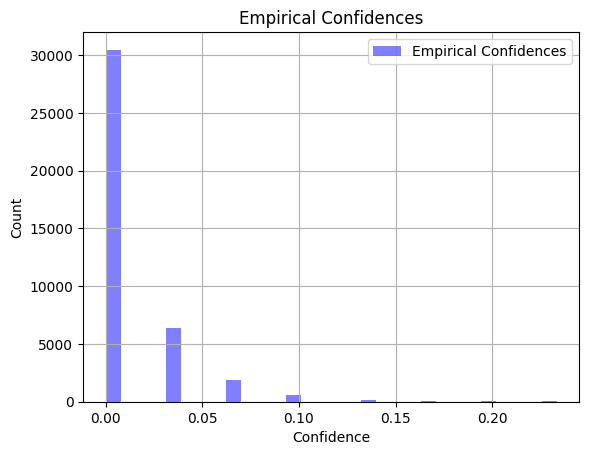

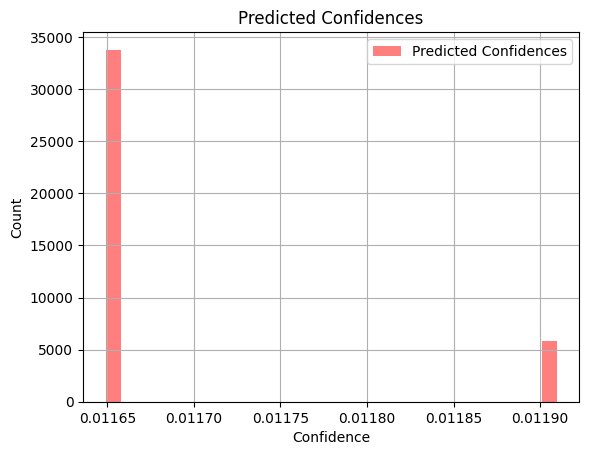

In [70]:
# create a histogram of the empirical confidences and the predicted confidences
import matplotlib.pyplot as plt

# --- Plot Histogram ---
plt.hist(targets, bins=30, alpha=0.5, label='Empirical Confidences', color='blue')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Empirical Confidences')
plt.legend()
plt.grid()
plt.show()

plt.hist(predictions, bins=30, alpha=0.5, label='Predicted Confidences', color='red')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Predicted Confidences')
plt.legend()
plt.grid()
plt.show()

In [71]:
# calculate the unique value count of the preds
unique_preds = np.unique(predictions, return_counts=True)
print(unique_preds)

(array([0.01164903, 0.01190953], dtype=float32), array([33777,  5793]))


## Final layer without vllm

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Use bfloat16 for efficiency
dtype = torch.bfloat16  
model_id = "meta-llama/Llama-3.2-1B-Instruct"

# Detect available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, max_length=3000)

# Load model and move to GPU before setting attn_implementation
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    torch_dtype=dtype, 
).to(device)  # Move to GPU before setting Flash Attention

# Now set attention mechanism (after moving model to GPU)
model.config.attn_implementation = "flash_attention_2"

# Ensure model is in evaluation mode
model.eval()

/home/rkhanm1/anaconda3/envs/vllm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

In [2]:
# Modified to store only the last token's hidden state
hidden_states_list = []

def get_hidden_states_hook(module, input, output):
    if isinstance(output, tuple):
        # Extract only the last token's hidden state for each item in batch
        hidden_states_list.append(output[0][:, -1, :])  # Shape: (batch_size, hidden_dim)
    else:
        hidden_states_list.append(output[:, -1, :])  # Shape: (batch_size, hidden_dim)

# Register hook on the last transformer layer
for name, module in model.named_modules():
    if "model.layers" in name and name.endswith(str(len(model.model.layers) - 1)):  # Last transformer layer
        module.register_forward_hook(get_hidden_states_hook)

# Ensure tokenizer has a padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use EOS token for padding

# Create a batch of 100 identical sentences
batch_size = 30
text = [" ".join(["hey"] * 3000)] * batch_size

# Tokenize input batch with padding
inputs = tokenizer(
    text, 
    return_tensors="pt", 
    padding=True, 
    truncation=True, 
    max_length=3000
).to(device)

# Clear previous hidden states
hidden_states_list.clear()

# Run inference
with torch.no_grad():
    model(**inputs)

# Extract final hidden states
final_hidden_states = hidden_states_list[-1]  # Shape: (batch_size, seq_len, hidden_dim)

# Print shape to verify
print(f"Final Hidden States Shape: {final_hidden_states.shape}")  # Expected: (batch_size, seq_len, hidden_dim)

Final Hidden States Shape: torch.Size([30, 2048])


## Attention Extraction

In [18]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [12]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

dtype = torch.bfloat16
model_id = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, max_length=3000)
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    torch_dtype=dtype, 
    attn_implementation="flash_attention_2",
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Store attention activations
attention_maps = []

# Hook function to capture attention weights
def get_attention_hook(module, input, output):
    attention_maps.append(output)  # Store only attention activations

# Register hooks for each attention layer
for name, module in model.named_modules():
    if "attention" in name and hasattr(module, "forward"):
        module.register_forward_hook(get_attention_hook)

# Tokenize input (DO NOT change dtype of input_ids!)
text = "This is a test input."
inputs = tokenizer(text, return_tensors="pt").to(device)

# Ensure dtype consistency for model inputs
inputs["input_ids"] = inputs["input_ids"].to(torch.long)  # Keep input_ids as int
if "attention_mask" in inputs:
    inputs["attention_mask"] = inputs["attention_mask"].to(dtype)  # Convert mask to dtype

# Run inference
with torch.no_grad():
    model(**inputs)

# Display attention activations
for i, attn in enumerate(attention_maps):
    print(f"Layer {i} Attention Shape: {attn[0].shape}")  # (batch_size, num_heads, seq_len, seq_len)


You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Layer 0 Attention Shape: torch.Size([7, 4096])
Layer 1 Attention Shape: torch.Size([7, 4096])
Layer 2 Attention Shape: torch.Size([7, 4096])
Layer 3 Attention Shape: torch.Size([7, 4096])
Layer 4 Attention Shape: torch.Size([7, 4096])
Layer 5 Attention Shape: torch.Size([7, 4096])
Layer 6 Attention Shape: torch.Size([7, 4096])
Layer 7 Attention Shape: torch.Size([7, 4096])
Layer 8 Attention Shape: torch.Size([7, 4096])
Layer 9 Attention Shape: torch.Size([7, 4096])
Layer 10 Attention Shape: torch.Size([7, 4096])
Layer 11 Attention Shape: torch.Size([7, 4096])
Layer 12 Attention Shape: torch.Size([7, 4096])
Layer 13 Attention Shape: torch.Size([7, 4096])
Layer 14 Attention Shape: torch.Size([7, 4096])
Layer 15 Attention Shape: torch.Size([7, 4096])
Layer 16 Attention Shape: torch.Size([7, 4096])
Layer 17 Attention Shape: torch.Size([7, 4096])
Layer 18 Attention Shape: torch.Size([7, 4096])
Layer 19 Attention Shape: torch.Size([7, 4096])
Layer 20 Attention Shape: torch.Size([7, 4096])
La

In [17]:
import torch
from transformers import AutoModel, AutoTokenizer

# Ensure the tokenizer has a padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# Store attention activations
attention_maps = []

# Hook function to capture attention weights
def get_attention_hook(module, input, output):
    attention_maps.append(output)  # Store only attention activations

# Register hooks for each attention layer
for name, module in model.named_modules():
    if "attention" in name and hasattr(module, "forward"):
        module.register_forward_hook(get_attention_hook)

# Create a batch of 100 identical sentences
batch_size = 5
text = [" ".join(["hey"] * 3000)] * batch_size

# Tokenize input batch
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

# Clear previous attention maps
attention_maps.clear()

# Run inference
with torch.no_grad():
    model(**inputs)

# Display attention activations
for i, attn in enumerate(attention_maps):
    print(f"Layer {i} Attention Shape: {attn[0].shape}")  # (batch_size, num_heads, seq_len, seq_len)

Layer 0 Attention Shape: torch.Size([3001, 4096])
Layer 1 Attention Shape: torch.Size([3001, 4096])
Layer 2 Attention Shape: torch.Size([3001, 4096])
Layer 3 Attention Shape: torch.Size([3001, 4096])
Layer 4 Attention Shape: torch.Size([3001, 4096])
Layer 5 Attention Shape: torch.Size([3001, 4096])
Layer 6 Attention Shape: torch.Size([3001, 4096])
Layer 7 Attention Shape: torch.Size([3001, 4096])
Layer 8 Attention Shape: torch.Size([3001, 4096])
Layer 9 Attention Shape: torch.Size([3001, 4096])
Layer 10 Attention Shape: torch.Size([3001, 4096])
Layer 11 Attention Shape: torch.Size([3001, 4096])
Layer 12 Attention Shape: torch.Size([3001, 4096])
Layer 13 Attention Shape: torch.Size([3001, 4096])
Layer 14 Attention Shape: torch.Size([3001, 4096])
Layer 15 Attention Shape: torch.Size([3001, 4096])
Layer 16 Attention Shape: torch.Size([3001, 4096])
Layer 17 Attention Shape: torch.Size([3001, 4096])
Layer 18 Attention Shape: torch.Size([3001, 4096])
Layer 19 Attention Shape: torch.Size([300

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


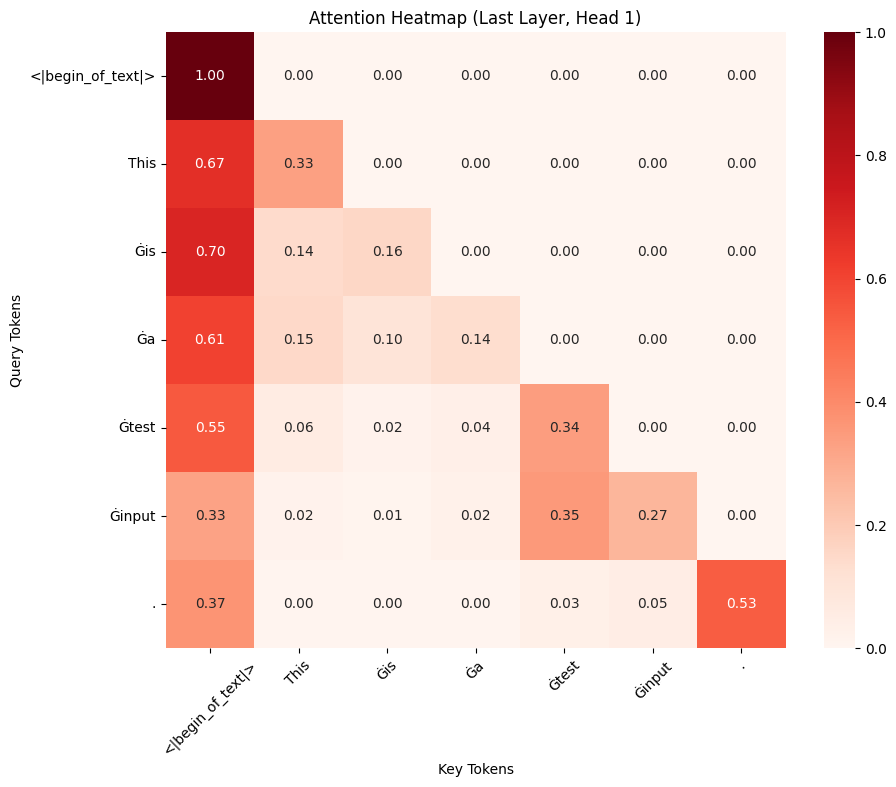

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModel, AutoTokenizer

# Load model and tokenizer
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Make sure this model exists
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to extract attention maps for a single input
def get_attention_weights(text):
    attention_maps = []

    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt").to(device)

    # Run inference with output_attentions=True
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention maps from model output
    attention_maps = outputs.attentions  # This should be a tuple of (num_layers, batch, num_heads, seq_len, seq_len)

    return attention_maps, inputs

# Sample text
text = "This is a test input."

# Extract attention maps and inputs
attention_maps, inputs = get_attention_weights(text)

# Check if attention maps are present
if not attention_maps:
    raise ValueError("Attention outputs are missing. Ensure your model supports 'output_attentions=True'.")

# Select last layer and first attention head
last_layer_attention = attention_maps[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)
attention_matrix = last_layer_attention[0, 0].cpu().numpy()  # First sample, first head

# Get tokens correctly
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])  # Extract tokenized input

# Ensure matrix is square
seq_len = len(tokens)
if attention_matrix.shape[0] != seq_len or attention_matrix.shape[1] != seq_len:
    print(f"Warning: Expected {seq_len}x{seq_len} attention matrix but got {attention_matrix.shape}")

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="Reds", annot=True, fmt=".2f")
plt.title("Attention Heatmap (Last Layer, Head 1)")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## Confidence with Attention

In [9]:
import os
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from transformers import AutoTokenizer
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [17]:
import os
import torch
import numpy as np
from torch import nn
from torch.optim import Adam
from transformers import AutoModelForCausalLM, AutoTokenizer

# --- Model Setup ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
dtype = torch.float16  # Switch to fp16

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set max sequence length
max_seq_length = 2300
tokenizer.model_max_length = max_seq_length

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load LLM with Flash Attention 2 in fp16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=dtype, 
    attn_implementation="flash_attention_2"
).to(device)
model.eval()

print(f"✅ Loaded model on {device} with Flash Attention 2 in {dtype}")

# Determine hidden size dynamically
if '1B' in model_name:
    hidden_size = 2048
elif '3B' in model_name:
    hidden_size = 3072
elif '8B' in model_name:
    hidden_size = 4096
else:
    raise ValueError(f"Unknown model size for {model_name}")

# --- Attention Extraction ---
attention_maps = []

def get_attention_hook(module, input, output):
    """Stores only attention weights, discarding hidden states."""
    if isinstance(output, tuple):  # Some models return (attn_output, attn_weights)
        attention_maps.append(output[1])  # Extract only attention weights
    else:
        attention_maps.append(output)  # Otherwise, store normally

# Register hooks to extract attention weights
for name, module in model.named_modules():
    if "self_attn" in name:  # Ensure we only capture attention layers
        module.register_forward_hook(get_attention_hook)

print(f"✅ Registered attention hooks for self-attention layers")

# --- Define Confidence Head ---
class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

# Initialize confidence head
confidence_head = ConfidenceHead(hidden_size).to(device)
print(f"✅ Confidence head initialized")

# Optimizer & Loss
optimizer = Adam(confidence_head.parameters(), lr=1e-4)
criterion = nn.BCELoss()  

print(f"✅ Optimizer & Loss set up")

✅ Loaded model on cuda with Flash Attention 2 in torch.float16
✅ Registered attention hooks for self-attention layers
✅ Confidence head initialized
✅ Optimizer & Loss set up


In [18]:
from torch.utils.data import DataLoader
from datasets import Dataset

# --- DataLoader Setup ---
batch_q = 1
nruns = 30
flattened_batch_size = batch_q * nruns

hf_train_dataset = Dataset.from_list(dataset_flat["train"])
hf_test_dataset = Dataset.from_list(dataset_flat["test"])  # Add test set

def collate_fn(batch):
    """Tokenizes inputs and prepares data for model inference."""
    texts = [item["input_str"] for item in batch]
    targets = [item["empirical_confidence"] for item in batch]
    
    # Tokenize
    inputs = tokenizer(
        texts, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )
    
    # Move inputs to GPU
    inputs = {key: value.to(device) for key, value in inputs.items()}
    targets = torch.tensor(targets, dtype=torch.float32, device=device)
    
    return inputs, targets, texts  # Texts included for debugging if needed

# Train DataLoader
train_loader = DataLoader(
    hf_train_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=True
)

# Test DataLoader
test_loader = DataLoader(
    hf_test_dataset,
    batch_size=flattened_batch_size,
    collate_fn=collate_fn,
    shuffle=False
)

print(f"✅ DataLoaders initialized with batch size {flattened_batch_size}")

✅ DataLoaders initialized with batch size 30


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

num_epochs = 5  # Increased epochs
epoch_losses = []  # Store epoch losses

print(f"Training for {num_epochs} epochs over {len(hf_train_dataset)} samples ({len(train_loader)} batches per epoch).")

# --- Training Loop ---
scaler = torch.cuda.amp.GradScaler()  # Enable AMP training

for epoch in range(num_epochs):
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Loss: N/A")

    for batch_idx, (inputs, targets, texts) in enumerate(pbar):
        # Clear previous attention maps
        global attention_maps
        attention_maps.clear()  # Prevents memory leaks

        torch.cuda.empty_cache()  # Manually free GPU memory

        with torch.cuda.amp.autocast():  # Enable AMP mixed precision
            # Forward pass through LLM to obtain attention scores
            with torch.no_grad():
                model(**inputs, output_attentions=True, return_dict=True)

            # Debugging: Print number of attention maps captured
            print(f"\n🚀 Captured {len(attention_maps)} attention maps")

            # Ensure we have attention maps
            if not attention_maps:
                raise RuntimeError("⚠️ No attention maps captured! Check the hook registration.")

            # Print first captured attention map shape for debugging
            print(f"📏 First attention map shape: {attention_maps[0].shape if attention_maps else 'N/A'}")

            # Stack all captured attention maps
            total_attention = torch.stack(attention_maps)  # Expected Shape: (num_layers, batch, num_heads, seq, seq)

            # Print after stacking
            print(f"🧐 Total attention shape after stacking: {total_attention.shape}")

            # Ensure expected shape (num_layers, batch, num_heads, seq, seq)
            if total_attention.ndim != 5:
                raise RuntimeError(f"❌ Unexpected total_attention shape: {total_attention.shape}")

            # Average across heads and layers
            mean_attention = total_attention.mean(dim=[0, 2])  # Expected Shape: (batch, seq, seq)

            # Print mean_attention shape before reducing
            print(f"📏 Mean attention shape: {mean_attention.shape}")

            # Reduce to a single vector per batch
            attention_features = mean_attention.mean(dim=1)  # Expected Shape: (batch, attention_size)

            # Print final attention features shape
            print(f"✅ Attention features shape: {attention_features.shape}")

            # Ensure correct shape for attention_features
            if attention_features.ndim != 2:
                raise RuntimeError(f"❌ Unexpected attention_features shape: {attention_features.shape}")


            # Average across heads and layers
            mean_attention = total_attention.mean(dim=[1, 2])  # Expected Shape: (batch, seq, seq)
            
            # Print mean_attention shape before reducing
            print(f"📏 Mean attention shape: {mean_attention.shape}")

            # Reduce to a single vector per batch
            attention_features = mean_attention.mean(dim=1)  # Expected Shape: (batch, attention_size)

            # Print final attention features shape
            print(f"✅ Attention features shape: {attention_features.shape}")

            # Ensure correct shape for attention_features
            if attention_features.ndim != 2:
                raise RuntimeError(f"❌ Unexpected attention_features shape: {attention_features.shape}")

            # Forward pass through confidence head
            pred_conf = confidence_head(attention_features)
            loss = criterion(pred_conf, targets)


        # Backward pass with AMP
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        pbar.set_description(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

        # Clear cache periodically
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()

    pbar.close()
    avg_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_loss)  # Store loss
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("✅ Training complete.")

/tmp/ipykernel_59773/488615828.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable AMP training


Training for 5 epochs over 179370 samples (5979 batches per epoch).


Epoch 1 Loss: N/A:   0%|          | 0/5979 [00:00<?, ?it/s]/tmp/ipykernel_59773/488615828.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable AMP mixed precision
Epoch 1 Loss: N/A:   0%|          | 0/5979 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 16.48 GiB. GPU 0 has a total capacity of 39.39 GiB of which 16.31 GiB is free. Including non-PyTorch memory, this process has 23.07 GiB memory in use. Of the allocated memory 18.37 GiB is allocated by PyTorch, and 4.20 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
save_path = f"../storage/trained_models/{model_name.split('/')[-1]}-confidence-head"
os.makedirs(save_path, exist_ok=True)

# Save model state
torch.save(confidence_head.state_dict(), os.path.join(save_path, "confidence_head.pth"))
print(f"Confidence model saved to {save_path}/confidence_head.pth")

# Save tokenizer config for consistency
tokenizer.save_pretrained(save_path)
print(f"Tokenizer saved to {save_path}")

# Save optimizer state (optional, if resuming training)
torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pth"))
print(f"Optimizer state saved to {save_path}/optimizer.pth")

Confidence model saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head/confidence_head.pth
Tokenizer saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head
Optimizer state saved to ../storage/trained_models/meta-llama/Llama-3.2-1B-Instruct-confidence-head/optimizer.pth


In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid()
plt.show()

In [ ]:
import os
import torch
from transformers import AutoTokenizer
from torch import nn

reload_vllm = True
max_seq_length = 2300

# --- Paths ---
model_name = "meta-llama/Llama-3.2-1B-Instruct"
load_path = f"../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839"
confidence_model_path = os.path.join(load_path, "confidence_head.pth")
tokenizer_path = load_path
optimizer_path = os.path.join(load_path, "optimizer.pth")  # Optional

# --- Reload Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
print(f"✅ Tokenizer loaded from {tokenizer_path}")

# --- Reload vLLM Model (Frozen LLM) ---
if reload_vllm:
    from vllm import LLM
    llm = LLM(model=model_name, 
            task="reward", 
            gpu_memory_utilization=0.6, 
            tensor_parallel_size=1, 
            seed=the_seed)

# --- Define Confidence Head ---
class ConfidenceHead(nn.Module):
    def __init__(self, hidden_size):
        super(ConfidenceHead, self).__init__()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hidden_state):
        x = self.linear(hidden_state)
        conf = self.sigmoid(x)
        return conf.squeeze(-1)

# --- Reload Confidence Model ---
if '1B' in model_name:
    hidden_size = 2048
elif '8B' in model_name:
    hidden_size = 4096
confidence_head = ConfidenceHead(hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
confidence_head.to(device)

# Securely load model weights
confidence_head.load_state_dict(torch.load(confidence_model_path, map_location=device, weights_only=True))
confidence_head.eval()
print(f"✅ Confidence model loaded from {confidence_model_path}")

# --- Reload Optimizer (Optional, if resuming training) ---
optimizer = torch.optim.Adam(confidence_head.parameters(), lr=1e-4)

if os.path.exists(optimizer_path):
    optimizer.load_state_dict(torch.load(optimizer_path, map_location=device, weights_only=True))
    print(f"✅ Optimizer state loaded from {optimizer_path}")

criterion = nn.BCELoss()

✅ Tokenizer loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839
WARNING 02-18 12:43:22 arg_utils.py:1145] The model has a long context length (131072). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
INFO 02-18 12:43:22 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Llama-3.2-1B-Instruct', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=131072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConf

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.30it/s]



INFO 02-18 12:43:25 model_runner.py:1115] Loading model weights took 2.3185 GB
✅ Confidence model loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839/confidence_head.pth
✅ Optimizer state loaded from ../storage/trained_models/Llama-3.2-1B-Instruct-confidence-head-20250218-093839/optimizer.pth


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from netcal.metrics import ECE

# --- Testing Function ---
def compute_brier_score(y_true, y_pred):
    """Computes Brier Score for confidence estimation."""
    return np.mean((y_pred - y_true) ** 2)

def compute_ece(y_true, y_pred, bins=10):
    """Computes Expected Calibration Error (ECE) using netcal."""
    ece = ECE(bins=bins)  # Corrected parameter name
    return ece.measure(y_pred, y_true)

def compute_metrics(y_true, y_pred):
    """Computes Brier Score, Expected Calibration Error (ECE), and Confidence Interval Coverage."""
    brier_score = compute_brier_score(y_true, y_pred)
    ece = compute_ece(y_true, y_pred)

    return {
        "Brier Score": brier_score,
        "ECE": ece
    }

# --- Testing Function ---
def test_model(test_loader, llm, confidence_head, tokenizer, max_batches=None):
    """Runs the confidence model on the test set and returns predictions and targets."""
    confidence_head.eval()  # Set to evaluation mode
    all_preds = []
    all_targets = []
    
    if max_batches is None:
        max_batches = len(test_loader)

    with torch.no_grad():
        pbar = tqdm(test_loader, desc=f"Testing on {max_batches} batches")

        for batch_idx, (inputs, targets, texts) in enumerate(pbar):
            eos_hidden_states = []

            # Process each sample one by one due to vLLM constraints
            for text in texts:
                output = llm.encode(text, use_tqdm=False)  # Encode one at a time
                hidden_states = output[0].outputs.data  # Get hidden states
                
                eos_token_id = tokenizer.eos_token_id
                eos_index = inputs["input_ids"][0].tolist().index(eos_token_id)  # Find EOS index
                
                eos_hidden_state = hidden_states[eos_index]  # Extract EOS hidden state
                eos_hidden_states.append(eos_hidden_state)
            
            # Convert list to tensor
            eos_hidden_states = torch.stack(eos_hidden_states).to(device)  # Shape: (batch_size, hidden_size)

            # Forward pass through confidence head
            pred_conf = confidence_head(eos_hidden_states)

            # Store predictions and targets
            all_preds.extend(pred_conf.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            pbar.set_description(f"Processed Batch {batch_idx+1}/{max_batches}")

            # Stop after a limited number of batches
            if batch_idx >= max_batches - 1:
                break

        pbar.close()
    
    return np.array(all_targets), np.array(all_preds)

# --- Run Test and Compute Metrics ---
targets, predictions = test_model(test_loader, llm, confidence_head, tokenizer)

Processed Batch 44/44:  98%|█████████▊| 43/44 [24:53<00:34, 34.74s/it]


In [ ]:
test_metrics = compute_metrics(targets, predictions)
print(test_metrics)

{'Brier Score': 0.0005850422, 'ECE': 0.75859334874853}


In [ ]:
import torch

# --- Single Sample Testing ---
def test_one_sample(sample, llm, confidence_head, tokenizer):
    """Tests a single sample and prints its input, true confidence, and model output."""
    confidence_head.eval()  # Set model to evaluation mode

    # Extract input string and true confidence
    input_text = sample['input_str']
    true_confidence = sample['empirical_confidence']
    
    print(f"Text Input:\n{input_text}")
    print(f"True Confidence: {true_confidence:.4f}")

    with torch.no_grad():
        # Encode text using LLM
        output = llm.encode(input_text, use_tqdm=False)  # Encode single input
        hidden_states = output[0].outputs.data  # Get hidden states
        
        # Find EOS token
        eos_token_id = tokenizer.eos_token_id
        eos_index = input_text.find(tokenizer.decode([eos_token_id]))  # Locate EOS token
        
        # Extract EOS hidden state
        eos_hidden_state = hidden_states[eos_index].unsqueeze(0).to(device)  # Shape: (1, hidden_size)
        
        # Forward pass through confidence head
        pred_conf = confidence_head(eos_hidden_state)
        predicted_confidence = pred_conf.item()

    print(f"Predicted Confidence: {predicted_confidence:.4f}")

# --- Run Single Sample Test ---
test_one_sample(dataset_flat['test'][950], llm, confidence_head, tokenizer)

Text Input:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 18 Feb 2025

You are a mathematics expert. You will be given a mathematics problem which you need to solve. Provide the final answer clearly at the end in the format: #### <final answer>.<|eot_id|><|start_header_id|>user<|end_header_id|>

Question: Summer and Jolly both went to the same middle school. However, when they finished college, Summer had five more degrees than Jolly. If Summer has a total of 150 degrees, what's the combined number of degrees they both have?
Answer: Jolly has 150 - 5 = <<150-5=145>>145 degrees
Since Summer has 150 degrees, the combined total for both is 150+145 = <<150+145=295>>295
#### 295

Question: Martin is casting three bells for the church's belfry. The first bell takes 50 pounds of bronze, the second bell is twice the size of the first bell, and the third bell is four times the size of the second bell. How much bronze does he need 

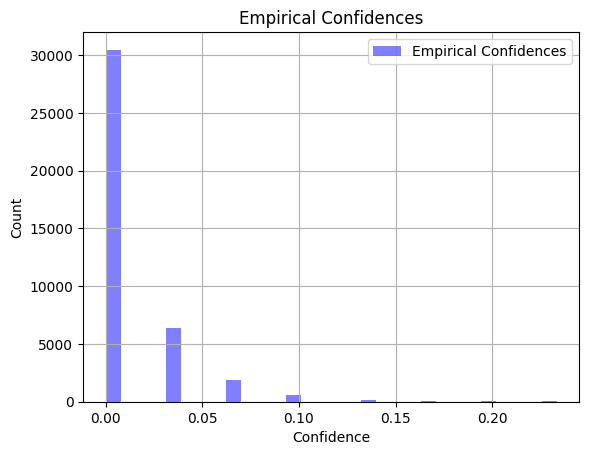

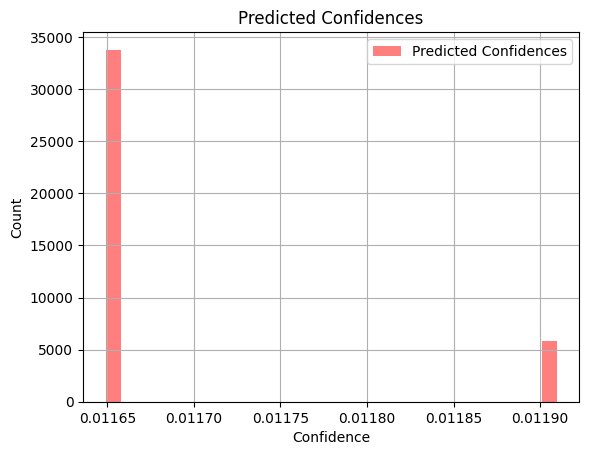

In [ ]:
# create a histogram of the empirical confidences and the predicted confidences
import matplotlib.pyplot as plt

# --- Plot Histogram ---
plt.hist(targets, bins=30, alpha=0.5, label='Empirical Confidences', color='blue')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Empirical Confidences')
plt.legend()
plt.grid()
plt.show()

plt.hist(predictions, bins=30, alpha=0.5, label='Predicted Confidences', color='red')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Predicted Confidences')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# calculate the unique value count of the preds
unique_preds = np.unique(predictions, return_counts=True)
print(unique_preds)

(array([0.01164903, 0.01190953], dtype=float32), array([33777,  5793]))
